# Photometry plots

In [1]:
from pathlib import Path
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

from ssi import SSI, LORRI
from ssi.geol import EUROPA

## Load data

In [2]:
def load_img(img_id):
    """Load image based on filename."""
    if img_id.startswith('C'):
        return SSI(f'IMG/{img_id}.pho.cub')
    
    elif img_id.startswith('lor_'):
        return LORRI(f'IMG/{img_id}.pho.cub')
    
    else:
        raise ValueError(f'Image id invalide: `{img_id}`')

img = load_img('C0349875100R')
img

FileNotFoundError: File `IMG/C0349875100R.pho.cub` not found.

In [3]:
Result = namedtuple('Result', 'img, instrument, filter, phase, unit, B0, dB0, k, dk, A, dA, f_alpha, df_alpha, color, marker')

SYMBOLS = {
    'VOYAGER_2_WIDE_ANGLE_CAMERA': '^',
    'VOYAGER_2_NARROW_ANGLE_CAMERA': 'v',
    'GALILEO_ORBITER_SOLID_STATE_IMAGING_SYSTEM': 'o',
    'NEW_HORIZONS_LORRI': 's',
}

ATTR = {
    'B0': '$B_0$',
    'k': '$k$',
    'A': '$A$',
    'f_alpha': '$f(\\alpha)$',
}

In [4]:
def load_csv(img_id):
    """Load results csv file."""
    img = load_img(img_id.replace('_0x630_sci', ''))
    data = np.loadtxt(f'csv/{img_id}.pho.csv', delimiter=', ', dtype=str)
    
    camera = '_'.join([img._inst['SpacecraftName'], img._inst['InstrumentId']]).replace(' ', '_').upper()
    
    return [
        Result(
            img.img_id,
            camera,
            img.filter_name,
            img.phase_angle,
            row[0],
            *[float(d) for d in row[1:]],
            EUROPA.color(row[0]),
            SYMBOLS[camera],
        )
        for row in data
    ]

load_csv('C0349875100R')

FileNotFoundError: File `IMG/C0349875100R.pho.cub` not found.

In [5]:
RESULTS = [
    res
    for csv in Path('csv').glob('*.csv')
    for res in load_csv(csv.stem.replace('.pho', ''))
]

In [6]:
{res.unit for res in RESULTS}

set()

## Plots

In [7]:
def data(attr, unit):
    return [(
        res.phase, 
        getattr(res, attr),
        getattr(res, 'd' + attr),
        res.color,
        res.marker,
    ) for res in RESULTS
    if res.unit == unit and not np.isnan(getattr(res, attr))]

data('B0', 'Ridged plains')[0]

IndexError: list index out of range

In [8]:
XMIN, XMAX = 0, 130
YMIN, YMAX = 0, 1.5

XTICKS = np.arange(XMIN, XMAX, 20)
XLABELS = [f'{x}°' for x in XTICKS]

def plot(ax, attr, units):
    if isinstance(units, str):
        units = [units]
    
    xx, yy = [], []
    for unit in units:
        for x, y, yerr, c, m in data(attr, unit):
            xx.append(x)
            yy.append(y)
            
            ax.plot(x, y, color=c, marker=m)
            ax.errorbar(x, y, yerr=yerr, ecolor=c, fmt='None')
            
        # Unit legend label (dummy)
        ax.plot([], [], 'o', color=c, label=unit)
    
    a, b = np.polyfit(xx, yy, 1, cov=True)
    ax.plot([XMIN, XMAX], [a * XMIN + b, a * XMAX + b], 'r-', lw=1, label='Linear Fit')
    
    ax.legend()
    
    ax.set_xlim(XMIN, XMAX)
    ax.set_ylim(YMIN, YMAX)
    
    ax.set_xticks(XTICKS)
    ax.set_xticklabels(XLABELS)

    ax.set_xlabel('Phase angle')
    ax.set_ylabel(ATTR[attr])

UnboundLocalError: local variable 'c' referenced before assignment

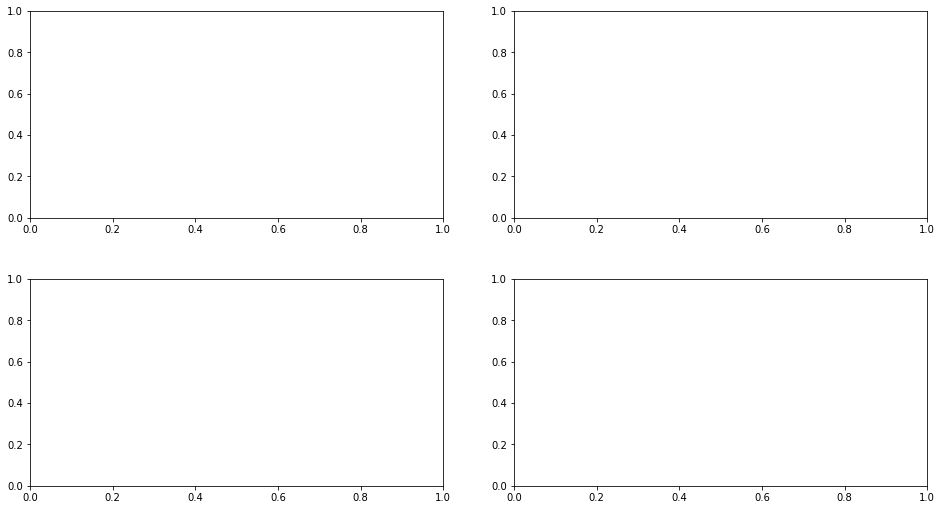

In [9]:
units = ['Ridged plains', 'Bands']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout(pad=4)

plot(axes[0, 0], 'B0', units)
plot(axes[0, 1], 'k', units)
plot(axes[1, 0], 'A', units)
plot(axes[1, 1], 'f_alpha', units)

axes[0, 0].set_title('(A)')
axes[0, 1].set_title('(B)')
axes[1, 0].set_title('(C)')
axes[1, 1].set_title('(D)')

# Add instrument secondary legend (dummy)
ax = axes[0, 0].twinx()
for inst, marker in SYMBOLS.items():
    ax.plot([], [], ls='None', color='w', markeredgecolor='k',
            marker=marker, label=inst.replace('_', ' ').title())

ax.legend(loc='upper left')
ax.axis('off')

plt.savefig('Photometry-Plain_Bands.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

UnboundLocalError: local variable 'c' referenced before assignment

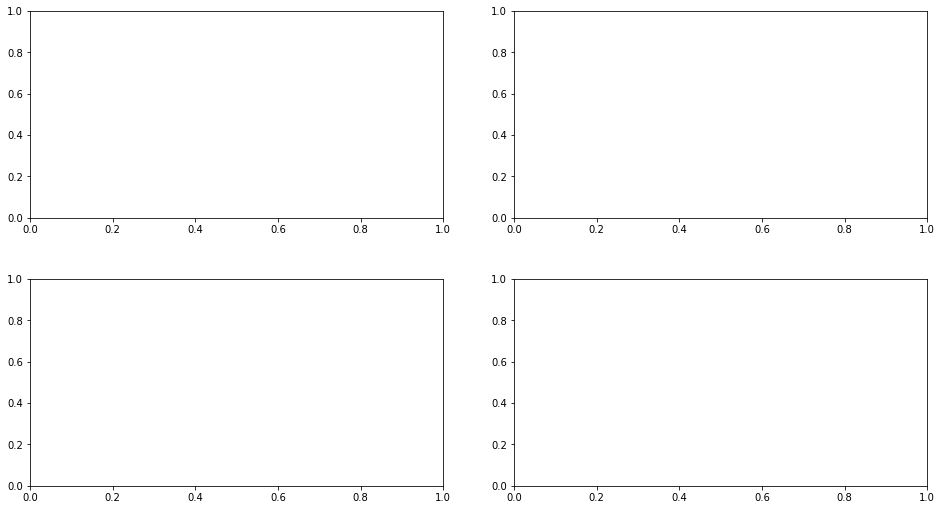

In [10]:
units = ['Low albedo chaos', 'Mottled albedo chaos', 'High albedo chaos']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout(pad=4)

plot(axes[0, 0], 'B0', units)
plot(axes[0, 1], 'k', units)
plot(axes[1, 0], 'A', units)
plot(axes[1, 1], 'f_alpha', units)

axes[0, 0].set_title('(A)')
axes[0, 1].set_title('(B)')
axes[1, 0].set_title('(C)')
axes[1, 1].set_title('(D)')

plt.savefig('Photometry-Chaos.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

UnboundLocalError: local variable 'c' referenced before assignment

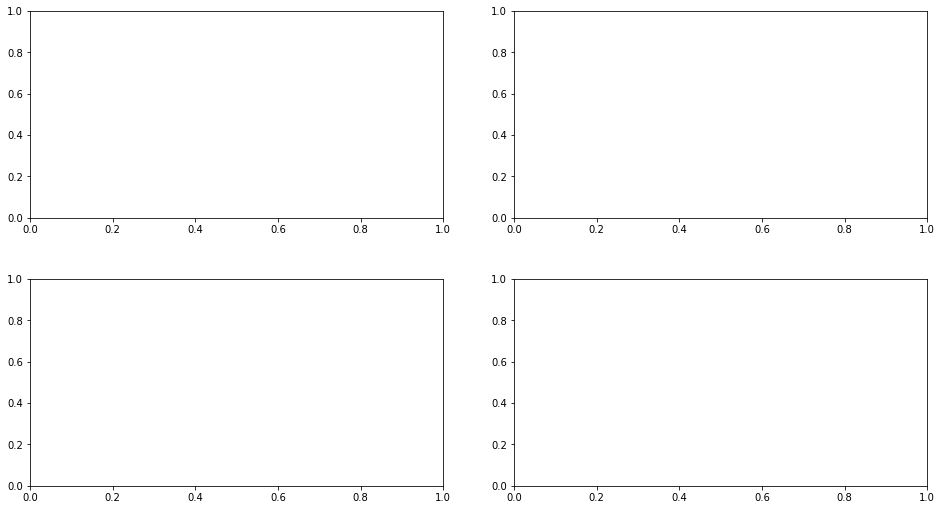

In [11]:
units = ['Crater', 'Continuous crater ejecta']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout(pad=4)

plot(axes[0, 0], 'B0', units)
plot(axes[0, 1], 'k', units)
plot(axes[1, 0], 'A', units)
plot(axes[1, 1], 'f_alpha', units)

axes[0, 0].set_title('(A)')
axes[0, 1].set_title('(B)')
axes[1, 0].set_title('(C)')
axes[1, 1].set_title('(D)')

plt.savefig('Photometry-Crater.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Photometry fit results

In [12]:
def fit(attr, unit):
    x, y, *_ = np.transpose(data(attr, unit))
    return np.polyfit(x.astype(float), y.astype(float), 1)

fit('B0', 'Ridged plains')

array([-0.00244979,  0.72826391])

In [13]:
def table_fits(units):
    # Header
    print(25 * ' ', end='')
    for attr in ATTR.keys():
        print(f' & {attr:^15}', end='')
    
    print(r' \\')

    print(f'{"Units":25}', end='')
    for attr in ATTR.keys():
        print(f' & {"a":^6} & {"b":^6}', end='')
    
    print(r' \\')
    print(100 * '-')
    
    # Data
    for unit in units:
        print(f'{unit:25}', end='')
        
        for attr in ATTR.keys():
            a, b = fit(attr, unit)
            print(f' & {a:6.3f} & {b:6.3f}', end='')
            
        print(r' \\')
        
table_fits([
    'Ridged plains',
    'Bands',
    'High albedo chaos',
    'Mottled albedo chaos',
    'Low albedo chaos',
    'Crater',
    'Continuous crater ejecta',  
])

                          &       B0        &        k        &        A        &     f_alpha     \\
Units                     &   a    &   b    &   a    &   b    &   a    &   b    &   a    &   b    \\
----------------------------------------------------------------------------------------------------
Ridged plains             & -0.002 &  0.728 &  0.004 &  0.532 & -0.003 &  0.871 & -0.014 &  1.556 \\
Bands                     & -0.003 &  0.739 &  0.003 &  0.563 & -0.002 &  0.868 & -0.012 &  1.499 \\
High albedo chaos         & -0.011 &  1.726 & -0.001 &  1.046 &  0.000 &  0.402 & -0.012 &  1.092 \\
Mottled albedo chaos      & -0.001 &  0.647 &  0.004 &  0.541 & -0.003 &  0.905 & -0.004 &  1.081 \\
Low albedo chaos          &  0.002 &  0.487 &  0.008 &  0.358 & -0.004 &  0.968 & -0.036 &  2.372 \\
Crater                    & -0.008 &  1.056 & -0.007 &  1.158 &  0.013 & -0.150 & -0.019 &  2.224 \\
Continuous crater ejecta  & -0.005 &  0.940 & -0.006 &  1.036 &  0.005 &  0.396 & -0.305 & 